## Neural networks for segmentation

In [1]:
!wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
!unzip -q data.zip

--2021-04-16 20:50:47--  https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/jy34yowcf85ydba/data.zip [following]
--2021-04-16 20:50:47--  https://www.dropbox.com/s/raw/jy34yowcf85ydba/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca3269130a5cace6e55b853b9a8.dl.dropboxusercontent.com/cd/0/inline/BMv5IslxLH4A5j8io86E70khMUfR5FmofM8G7qcKZjePYu7tqaRyX2PqjRLTglM-xA9s47jFLKAN_5FvUzco4CVoNzpouoh6sUMlrPYZwug9liOImdkQtNRsJ3sBoPU0D1X7sNkDdvRowcjydVxW70Kt/file# [following]
--2021-04-16 20:50:47--  https://uca3269130a5cace6e55b853b9a8.dl.dropboxusercontent.com/cd/0/inline/BMv5IslxLH4A5j8io86E70khMUfR5FmofM8G7qcKZjePYu7tqaRyX2PqjRLTglM-xA9s47jFLKAN_5FvUzco4CVoNzpouoh6s

In [2]:
%pip install scikit-image
!pip install -U git+https://github.com/albu/albumentations > /dev/null 

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-e_5op0vs


In [3]:
! pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 16.3MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp37-none-any.whl size=65163 sha256=67d5555dfd1796ae4750d71fb50fa995a5327617bf1e83058a00e5610fa708f4
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: albumentations 0.5.2
    Uninstalling albumentations-0.5.2:
      Successfully uninstalled albumentations-0.5.2


Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [4]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import skimage
%matplotlib inline

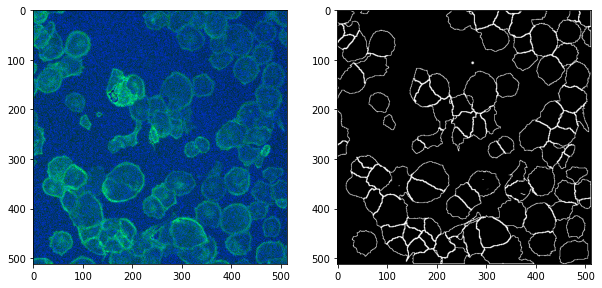

In [5]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = skimage.img_as_ubyte(skimage.io.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp'))
plt.imshow(im)
plt.subplot(1,2,2)
mask = skimage.img_as_ubyte(skimage.io.imread('BBBC018_v1_outlines/train/00735-cells.png'))
plt.imshow(mask, 'gray')

In [6]:
im.shape, mask.shape

((512, 512, 3), (512, 512))

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss. You also can try to use softIoU or DICE loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [7]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [8]:
import albumentations
import os
import random
import torch
import torch.nn as nn

from albumentations.pytorch import ToTensor
from PIL.Image import open
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class Dataset(Dataset):
    def __init__(self, img_dir, outlines_dir, mode, transform=None):
        super().__init__()

        if mode not in ["train", "test", "val"]:
            raise RuntimeError
        
        self.imgs = sorted(next(os.walk(img_dir))[2])
        if mode != "test":
            self.outline = sorted(next(os.walk(outlines_dir))[2])
        else:
            self.outline = []
        self.img_dir = img_dir
        self.outlines_dir = outlines_dir
        self.mode = mode
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img = skimage.io.imread(os.path.join(self.img_dir ,self.imgs[idx]))
        if self.mode != "test":
            outline = skimage.io.imread(os.path.join(self.outlines_dir, self.outline[idx]))
            
            if self.transform:
                aug = self.transform(image=img, mask=outline)
                img = aug['image']
                outline = aug['mask']
            return img, outline
        else:
            image_file_name = os.path.splitext(os.path.basename(self.imgs[idx]))[0]
            return self.transform(image=img)['image'], os.path.join(self.outlines_dir, image_file_name + ".png")

In [9]:
train_transform = albumentations.Compose([
    albumentations.RandomSizedCrop((256, 512), 512, 512, p=0.75),
    albumentations.HorizontalFlip(p=0.75),
    albumentations.RandomRotate90(p=0.75),
    ToTensor(),

])

val_transform = albumentations.Compose([
    ToTensor(),

])

train_dataset = Dataset('BBBC018_v1_images-fixed/train', 'BBBC018_v1_outlines/train', "train", transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size = 1, shuffle=True)

val_dataset = Dataset('BBBC018_v1_images-fixed/val', 'BBBC018_v1_outlines/val', "val", transform=val_transform)
val_dataloader = DataLoader(val_dataset, batch_size = 1, shuffle=False)

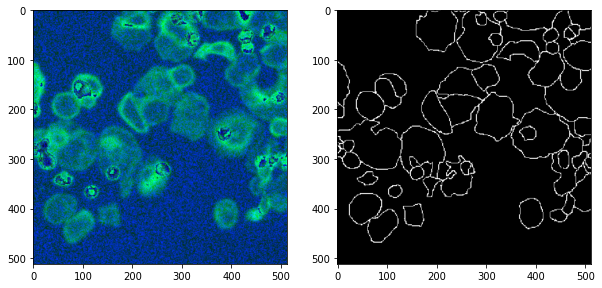

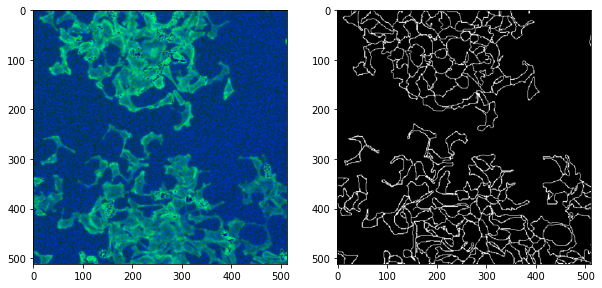

In [10]:
for i, (img, mask) in enumerate(train_dataloader):
    plt.figure(figsize=(10,8))

    plt.subplot(1,2,1)
    plt.imshow(img.numpy()[0].transpose((1, 2, 0)))

    plt.subplot(1,2,2)
    plt.imshow(mask.numpy()[0][0], 'gray')

    if i + 1 == 2:
        break

In [11]:
class Convs(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        
        if not mid_channels:
            mid_channels = out_channels
        
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=mid_channels,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=mid_channels),
            nn.ReLU(),

            nn.Conv2d(in_channels=mid_channels, out_channels=out_channels,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU()
        )
        
    def forward(self, x):
        return self.double_conv(x)

In [12]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            Convs(in_channels=in_channels, out_channels=out_channels),
            nn.MaxPool2d(kernel_size=2)
        )
    
    def forward(self, x):
        return self.conv(x)

In [13]:
class Up(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.double_conv = Convs(in_channels + mid_channels, out_channels, mid_channels)
        
    def forward(self, x, x2):
        x1 = self.upsample(x)
        x1 = torch.cat((x1, x2), dim=1)
        x1 = self.double_conv(x1)
        return x1

In [14]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = Convs(3, 32)
        self.input2 = Convs(32, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
    
        self.up1 = Up(1024, 512, 512)
        self.up2 = Up(512, 256, 256)
        self.up3 = Up(256, 128, 128)
        self.up4 = Up(128, 64, 64)
        self.out = Convs(64, 32)
        self.out_conv = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=1)
        
    def forward(self, x):
        x1 = self.input(x)
        x2 = self.input2(x1)
        x3 = self.down1(x2)
        x4 = self.down2(x3)
        x5 = self.down3(x4)
        x6 = self.down4(x5)
        x7 = self.up1(x6, x5)
        x8 = self.up2(x7, x4)
        x9 = self.up3(x8, x3)
        x10 = self.up4(x9, x2)
        x11 = self.out(x10)
        x12 = self.out_conv(x11)
        return x12

In [17]:
class LossBinary:
    """
    Loss defined as \alpha BCE - (1 - \alpha) SoftJaccard
    """

    def __init__(self, jaccard_weight=0):
        self.nll_loss = nn.BCEWithLogitsLoss()
        self.jaccard_weight = jaccard_weight

    def __call__(self, outputs, targets):
        loss = (1 - self.jaccard_weight) * self.nll_loss(outputs, targets)

        if self.jaccard_weight:
            eps = 1e-15
            jaccard_target = (targets == 1).float()
            jaccard_output = outputs.sigmoid()

            intersection = (jaccard_output * jaccard_target).sum()
            union = jaccard_output.sum() + jaccard_target.sum()

            loss -= self.jaccard_weight * torch.log((intersection + eps) / (union - intersection + eps))
        return loss

In [ ]:
model = UNet()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

device

device(type='cuda', index=0)

In [ ]:
criterion = LossBinary(0.5)
optimizer = torch.optim.Adam(model.parameters())

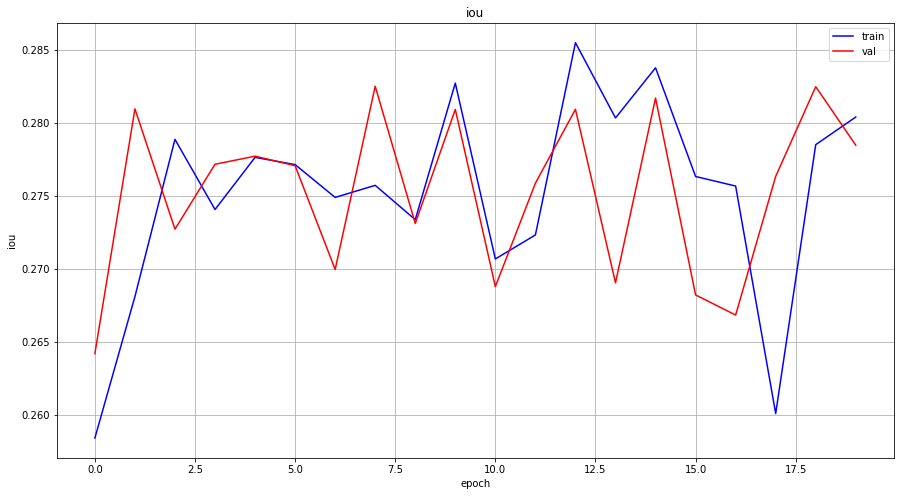

In [ ]:
from IPython import display


training_iou = []
val_iou = []

epochs = 20
limit = 0.5

for epoch in range(epochs):
    model.train(True)
    
    for img, mask in train_dataloader:
        optimizer.zero_grad()
        prediction = model(img.to(device))
        loss = criterion(prediction, mask.to(device))
        loss.backward()
        optimizer.step()

    model.train(False)

    prediction_train = []
    outline_train = []
    for img, mask in train_dataloader:
        prediction = model(img.to(device))
        prediction = (prediction.sigmoid() > limit).float().cpu().numpy()
        prediction_train += [prediction]
        outline_train += [mask.detach().numpy()]

    training_iou.append(calc_iou(prediction_train, outline_train))
    
    prediction_val = []
    outline_val = []
    for img, mask in val_dataloader:
        prediction = model(img.to(device))
        prediction = (prediction.sigmoid() > limit).float().cpu().numpy()
        prediction_val += [prediction]
        outline_val += [mask.detach().numpy()]
    val_iou.append(calc_iou(prediction_val, outline_val))
    
    display.clear_output(True)
    
    plt.figure(figsize=(15, 8))
    plt.title("iou")
    plt.xlabel("epoch")
    plt.ylabel("iou")
    plt.plot(training_iou, c="b", label="train")
    plt.plot(val_iou, c="r", label="val")
    plt.grid()
    plt.legend()
    plt.show()

In [15]:
class UNetImprove(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = Convs(3, 32)
        self.input2 = Convs(32, 64)

        self.down_1_0 = Down(64, 128)
        self.down_2_0 = Down(128, 256)
        self.down_3_0 = Down(256, 512)
        self.down_4_0 = Down(512, 1024)
    
        self.up_0_1 = Up(128, 64, 64)
        self.up_1_1 = Up(256, 128, 128)
        self.up_0_2 = Up(128, 64, 64)
        self.up_2_1 = Up(512, 256, 256)
        self.up_1_2 = Up(256, 128, 128)
        self.up_0_3 = Up(128, 64, 64)
        self.up_3_1 = Up(1024, 512, 512)
        self.up_2_2 = Up(512, 256, 256)
        self.up_1_3 = Up(256, 128, 128)
        self.up_0_4 = Up(128, 64, 64)
        
        self.out_conv1 = Convs(64, 32)
        self.out_conv2 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=1)
        
    def forward(self, x):
        x1 = self.input(x)
        x_0_0 = self.input2(x1)
        x_1_0 = self.down_1_0(x_0_0)
        x_0_1 = self.up_0_1(x_1_0, x_0_0)

        x_2_0 = self.down_2_0(x_1_0)
        x_1_1 = self.up_1_1(x_2_0, x_1_0)
        x_0_2 = self.up_0_2(x_1_1, x_0_1)

        x_3_0 = self.down_3_0(x_2_0)
        x_2_1 = self.up_2_1(x_3_0, x_2_0)
        x_1_2 = self.up_1_2(x_2_1, x_1_1)
        x_0_3 = self.up_0_3(x_1_2, x_0_2)

        x_4_0 = self.down_4_0(x_3_0)
        x_3_1 = self.up_3_1(x_4_0, x_3_0)
        x_2_2 = self.up_2_2(x_3_1, x_2_1)
        x_1_3 = self.up_1_3(x_2_2, x_1_2)
        x_0_4 = self.up_0_4(x_1_3, x_0_3)
 
        x_out = self.out_conv1(x_0_4)
        x_out_2 = self.out_conv2(x_out)

        return x_out_2

In [18]:
model_improve = UNetImprove()

criterion = LossBinary(0.5)
optimizer = torch.optim.Adam(model_improve.parameters())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_improve.to(device)

device

device(type='cuda', index=0)

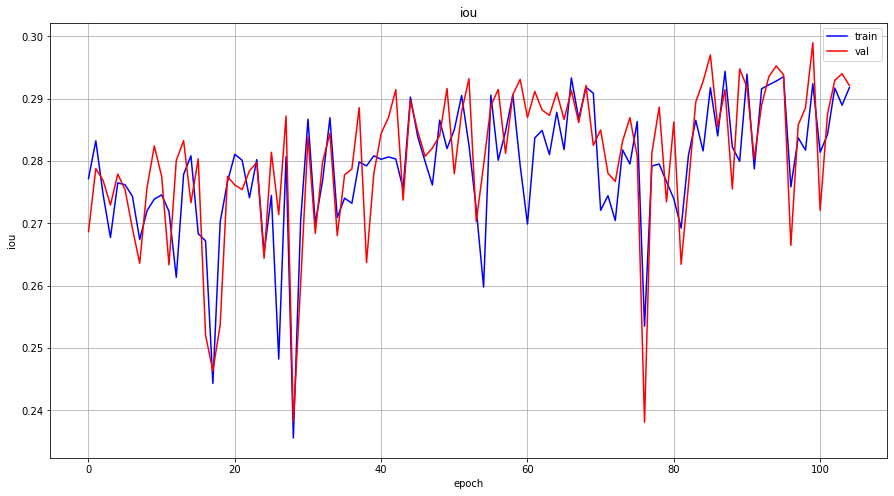

In [22]:
from IPython import display


# training_iou = []
# val_iou = []

epochs = 3
limit = 0.5

for epoch in range(epochs):
    model_improve.train(True)
    
    for img, mask in train_dataloader:
        optimizer.zero_grad()
        prediction = model_improve(img.to(device))
        loss = criterion(prediction, mask.to(device))
        loss.backward()
        optimizer.step()

    model_improve.train(False)

    prediction_train = []
    outline_train = []
    for img, mask in train_dataloader:
        prediction = model_improve(img.to(device))
        prediction = (prediction.sigmoid() > limit).float().cpu().numpy()
        prediction_train += [prediction]
        outline_train += [mask.detach().numpy()]

    training_iou.append(calc_iou(prediction_train, outline_train))
    
    prediction_val = []
    outline_val = []
    for img, mask in val_dataloader:
        prediction = model_improve(img.to(device))
        prediction = (prediction.sigmoid() > limit).float().cpu().numpy()
        prediction_val += [prediction]
        outline_val += [mask.detach().numpy()]
    val_iou.append(calc_iou(prediction_val, outline_val))
    
    display.clear_output(True)
    
    plt.figure(figsize=(15, 8))
    plt.title("iou")
    plt.xlabel("epoch")
    plt.ylabel("iou")
    plt.plot(training_iou, c="b", label="train")
    plt.plot(val_iou, c="r", label="val")
    plt.grid()
    plt.legend()
    plt.show()

In [24]:
print("iou on train data:", training_iou[-1])
print("iou on validate data:", val_iou[-1])

iou on train data: 0.2917796525383979
iou on validate data: 0.29210237049740734


In [25]:
test_transform = albumentations.Compose([
    ToTensor(),

])

In [26]:
!mkdir predictions

In [33]:
test_dataset = Dataset('BBBC018_v1_images-fixed/test', 'predictions', "test", test_transform)
test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

for img, path in test_dataloader:
    prediction = model_improve(img.to(device))
    prediction = (prediction.sigmoid() > limit).float().cpu().numpy()
    plt.imsave(path[0], prediction[0][0], cmap='gray')

Небольшой рассказ о том, что я сделала.

Изначально я написала обычную UNET с лекции (в ноутбуке приведен код), но получить оценку выше 0,28 у меня не получалось (наверное, надо больше данных и эпох). Немного погуглив (извините, пояндексив), я наткуналась на вот эту   [статью](https://towardsdatascience.com/biomedical-image-segmentation-unet-991d075a3a4b), где модифицифровали UNET. Было решено попробовать написать данную "треугольную" сетку и посмотреть качество на ней. В целом, она дала прирост качества и быстрее сходилась к 0.28, оставалось только дождаться, когда iou станет больше 0.29. Думаю, что, если сделать больше аугментированных данных и добавить эпох, она показала бы получше качество.

Полученное качество (iou):
*   train: 0.2918
*   val: 0.2921

